In [1]:
import pickle
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time

### Analysis of the Images (one Tumor per Image)
The aim of this analysis is to test if it is possible to destinguish between the 2 different tumours types. Therefore the net is trained with with the cropped images of the 2 tumour types.

#### Creation of Training, Validation and Testset
Approx 60% is for training, 20% for validation and 20% for testing. The borders are choosen so that no patient is splitt between the different sets.

In [2]:
start = time.time()
#Inselspital
with gzip.open('GBM_tumors.pickle.gz') as f:
    Names,X,Y = pickle.load(f)
print ("Loaded data in " + str(time.time() - start))
print ("   " + str(X.shape) + " y " + str(Y.shape))


gbm_test = 408

Y_train = Y[:gbm_test]
Y_test  = Y[gbm_test:]

X_train = X[:gbm_test,:,:,:]
X_test  = X[gbm_test:,:,:]

Loaded data in 0.130023002625
   (500, 1, 48, 48) y (500,)


In [3]:
start = time.time()
#Inselspital
with gzip.open('META_tumors.pickle.gz') as f:
    Names,X,Y = pickle.load(f)
print ("Loaded data in " + str(time.time() - start))
print ("   " + str(X.shape) + " y " + str(Y.shape))


meta_test = 340

Y_train = np.append(Y_train, Y[:meta_test])
Y_test = np.append(Y_test, Y[meta_test:])

X_train = np.concatenate((X_train, X[:meta_test,:,:,:]), axis=0)
X_test = np.concatenate((X_test, X[meta_test:,:,:,:]), axis=0)

Loaded data in 0.100171089172
   (429, 1, 48, 48) y (429,)


#### Random Permutations of the training set
In order that the minibatch sees as much variation of the data as possible, we permute the trainingset.

In [5]:
perm = np.random.permutation(len(Y_train))
X_train = X_train[perm,:,:,:]
y_train = Y_train[perm]

y = np.asarray(Y - 1,dtype='int32')
X = np.asanyarray(X,dtype='float32')

In [6]:
print(str(np.shape(X)) + " " + str(np.shape(y)))
print(str(np.shape(X_test)) + " " + str(np.shape(Y_test)))
y[1:10]

(429, 1, 48, 48) (429,)
(181, 1, 48, 48) (181,)


array([2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

### Normalization (Optional)

In [7]:
## Training
Xmean = X_train.mean(axis = 0)
XStd = np.sqrt(X_train.var(axis=0))
X_train = (X_train-Xmean)/(XStd + 0.01)

## Testing
Xmean = X_test.mean(axis = 0)
XStd = np.sqrt(X_test.var(axis=0))
X_test = (X_test-Xmean)/(XStd + 0.01)

#### The first try

before 0.278308570385 after 0.119576893747
before 0.364011883736 after -0.344519346952
before 0.297383785248 after 0.112733840942
before 0.386834412813 after 0.278512150049
before 0.4085688591 after 0.0883686691523
before 0.230788499117 after -0.0884730219841
before 0.28436177969 after -0.0356904566288
before 0.244297236204 after -0.114534974098
before 0.251798182726 after -0.270572721958
before 0.23939704895 after -0.313908606768
before 0.250112563372 after -0.628523588181
before 0.231947079301 after -0.520418047905
before 0.259793937206 after -0.0123958326876
before 0.242412507534 after 0.0346180461347
before 0.248966053128 after -0.208483159542
before 0.249141186476 after 0.251910299063
before 0.259120255709 after 0.0672411769629
before 0.254245132208 after 0.155393660069


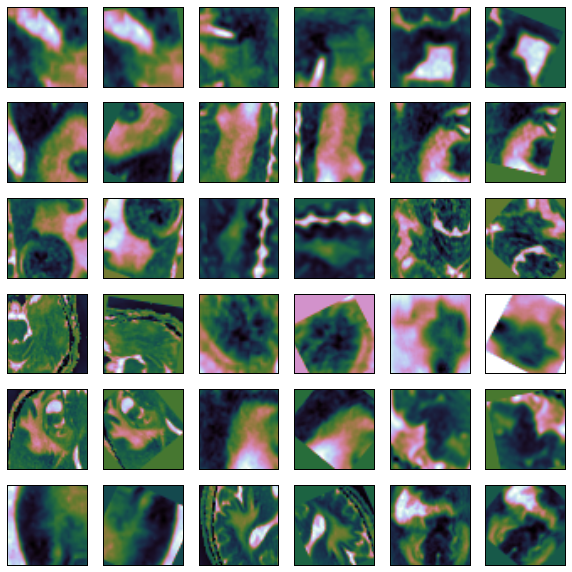

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from skimage import transform as tf

#rots = np.deg2rad(np.asarray((90,180,0,5,-5,10,-10)))
rots = np.deg2rad(range(0,359))


def manipulateTrainingData(Xb):
    retX = np.zeros((Xb.shape[0], Xb.shape[1], Xb.shape[2], Xb.shape[3]), dtype='float32')
    for i in range(len(Xb)):
        rot = rots[np.random.randint(0, len(rots))]
        tf_rotate = tf.SimilarityTransform(rotation=rot)
        shift_y, shift_x = np.array((X.shape[2], X.shape[3])) / 2.
        tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])
        tform_rot = (tf_shift + (tf_rotate + tf_shift_inv))

        ## TODO add the transformations
        scale = np.random.uniform(0.9,1.10)
        d = tf.SimilarityTransform(scale=scale, translation=(np.random.randint(5),np.random.randint(5)))
        tform_other = (tform_rot + d)
        
        c = 0
        retX[i,c,:,:] = tf.warp(Xb[i,c,:,:], tform_other, preserve_range = True) # "Float Images" are only allowed to have values between -1 and 1
    return retX

Xb = np.copy(X_train[0:100,:,:,:])
Xb = manipulateTrainingData(Xb)

fig = plt.figure(figsize=(10,10))
for i in range(18):
    a=fig.add_subplot(6,6,2*i+1,xticks=[], yticks=[])
    plt.imshow(X_train[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    a=fig.add_subplot(6,6,2*i+2,xticks=[], yticks=[])
    plt.imshow(Xb[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    print('before {0} after {1}'.format(np.mean(X[i,0,:,:]), np.mean(Xb[i,0,:,:])))

### A very Simple CNN

In [46]:
PIXELS = 48

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net_simple = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('dropout1', layers.DropoutLayer),
        
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('dropout2', layers.DropoutLayer),
        
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        
        ('hidden4', layers.DenseLayer),
        ('dropout4', layers.DropoutLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    conv1_num_filters=32, conv1_filter_size=(5, 5), pool1_pool_size=(2, 2), #pool_size used to be called ds in old versions of lasagne
    dropout1_p=0.0,
    
    conv2_num_filters=64, conv2_filter_size=(3, 3), pool2_pool_size=(2, 2),
    dropout2_p=0.3,
    
    hidden3_num_units=100,
    dropout3_p=0.3,
    
    hidden4_num_units=20,
    dropout4_p=0.3,
    
    output_num_units=3, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=200,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

In [9]:
PIXELS = 48
COLORS =  1 #The number of layers of the input image 1 (BW), 3 rgb, 5 for HCS data

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

conv = (3,3)
stride = (1,1)
pool = (2,2)

num1 = 32
num2 = 64
num3 = 128
num4 = 256
num5 = 256

net_bigger = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        
        ('conv1', layers.Conv2DLayer),
        ('conv11', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        
        ('conv2', layers.Conv2DLayer),
        ('conv22', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        
        ('conv3', layers.Conv2DLayer),
        ('conv33', layers.Conv2DLayer),
#        ('pool3', layers.MaxPool2DLayer),
        
#         ('conv4', layers.Conv2DLayer),
#         ('conv44', layers.Conv2DLayer),
#         ('pool4', layers.MaxPool2DLayer),
        
#         ('conv5', layers.Conv2DLayer),
#         ('conv55', layers.Conv2DLayer),
#         ('pool5', layers.MaxPool2DLayer),
                
              
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        
        ('hidden2', layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
        
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, COLORS, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    
    conv1_num_filters=num1, conv1_filter_size=conv, conv1_stride=stride, 
    conv11_num_filters=num1, conv11_filter_size=conv, conv11_stride=stride,
    pool1_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    conv2_num_filters=num2, conv2_filter_size=conv, conv2_stride=stride, 
    conv22_num_filters=num2, conv22_filter_size=conv, conv22_stride=stride,
    pool2_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    conv3_num_filters=num3, conv3_filter_size=conv, conv3_stride=stride, 
    conv33_num_filters=num3, conv33_filter_size=conv, conv33_stride=stride,
#    pool3_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
#     conv4_num_filters=num4, conv4_filter_size=conv, conv4_stride=stride, 
#     conv44_num_filters=num4, conv44_filter_size=conv, conv44_stride=stride,
#     pool4_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
#     conv5_num_filters=num5, conv5_filter_size=conv, conv5_stride=stride, 
#     conv55_num_filters=num5, conv55_filter_size=conv, conv55_stride=stride,
#     pool5_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    hidden1_num_units=200,
    dropout1_p=0.3,
    
    hidden2_num_units=200,
    dropout2_p=0.3,
    
    hidden3_num_units=50,
    dropout3_p=0.3,
    
    output_num_units=5, output_nonlinearity=nonlinearities.softmax,
    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=200,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce GTX 780


In [10]:
net1 = net_bigger

### With Augmentation

In [11]:
from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        #return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images
        return manipulateTrainingData(Xb), yb
    
# Setting the new batch iterator
net1Aug = net1
net1Aug.max_epochs = 800
net1Aug.batch_iterator_train = SimpleBatchIterator(50)
netAug = net1Aug.fit(X,y)

# Neural Network with 977137 learnable parameters

## Layer information

|   # | name     | size     |
|----:|:---------|:---------|
|   0 | input    | 1x48x48  |
|   1 | conv1    | 32x46x46 |
|   2 | conv11   | 32x44x44 |
|   3 | pool1    | 32x22x22 |
|   4 | conv2    | 64x20x20 |
|   5 | conv22   | 64x18x18 |
|   6 | pool2    | 64x9x9   |
|   7 | conv3    | 128x7x7  |
|   8 | conv33   | 128x5x5  |
|   9 | hidden1  | 200      |
|  10 | dropout1 | 200      |
|  11 | hidden2  | 200      |
|  12 | dropout2 | 200      |
|  13 | hidden3  | 50       |
|  14 | dropout3 | 50       |
|  15 | output   | 5        |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.48057       1.21946      1.21411      1.00000  0.56s
      2       0.93358       0.39113      2.38690      1.00000  0.54s
      3       0.14411       0.00001  10867.62402      1.00000  0.54s
      4       0.00042       0.00000        

/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "
/usr/local/lib/python2.7/dist-packages/Lasagne-0.1dev-py2.7.egg/lasagne/layers/helper.py:69: UserWarning: get_all_layers() has been changed to return layers in topological order. The former implementation is still available as get_all_layers_old(), but will be removed before the first release of Lasagne. To ignore this warning, use `warnings.filterwarnings('ignore', '.*topo.*')`.
  warnings.warn("get_all_layers() has been changed to return layers in "


### Without Augmentation

In [36]:
net = net1.fit(X,y)

# Neural Network with 661511 learnable parameters

## Layer information

|   # | name     | size     |
|----:|:---------|:---------|
|   0 | input    | 1x48x48  |
|   1 | conv1    | 32x44x44 |
|   2 | pool1    | 32x22x22 |
|   3 | dropout1 | 32x22x22 |
|   4 | conv2    | 64x20x20 |
|   5 | pool2    | 64x10x10 |
|   6 | dropout2 | 64x10x10 |
|   7 | hidden3  | 100      |
|   8 | dropout3 | 100      |
|   9 | hidden4  | 20       |
|  10 | dropout4 | 20       |
|  11 | output   | 3        |

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.01175       0.77541      1.30480      0.54794  0.24s
      2       0.81221       0.71690      1.13295      0.45206  0.22s
      3       0.76525       0.71822      1.06548      0.45206  0.21s
      4       0.74696       0.69714      1.07146      0.54368  0.21s
      5       0.72259       0.69750      1.03598      0.50213  0.21s
      6       0.72579    

In [31]:
y[1:10]

array([1, 2, 1, 1, 2, 2, 1, 1, 1], dtype=int32)

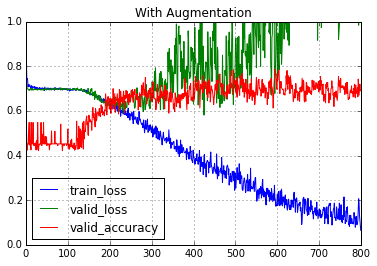

In [59]:
%matplotlib inline
import pandas as pd
dfNoAug = pd.DataFrame(netAug.train_history_)
dfNoAug[['train_loss','valid_loss','valid_accuracy']].plot(title='With Augmentation', ylim=(0,1))

### Using the untouched test-set

In [41]:
X_test = np.asanyarray(X_test,dtype='float32')
pred = net.predict(X_test)
np.sum(pred  == np.asanyarray(y_test - 1, dtype='int32')) / (1.0*len(y_test))

0.65745856353591159